In [5]:
import numpy as np

import matplotlib.pyplot as plt

import sys
sys.path.append('../src')

from single_compartment_model import SingleCompartmentModel
plt.style.use('default')

# Simulation
A single compartment model was implemented and approximated using backward euler approximation

In [6]:
model = SingleCompartmentModel(
    C_m=1,
    E_Na=115,
    E_K=-12,
    E_L=10.6,
    E_m=0,
    g_Na=120,
    g_K=36,
    g_L=0.3
)

V = np.arange(-50, 150, 1)
m = [model.m_inf(v) for v in V]
h = [model.h_inf(v) for v in V]
n = [model.n_inf(v) for v in V]

In order to properly set the initial values the steady state values for $m$, $n$ and $h$ had to be calculated.
It is done by calculating 1000 steps of each approximation and maintaining a constant voltage.
The result is presented on the figure below.

The initial values are those for $V = 0$ mV and are marked on the plots as the intersection with the horizontal line

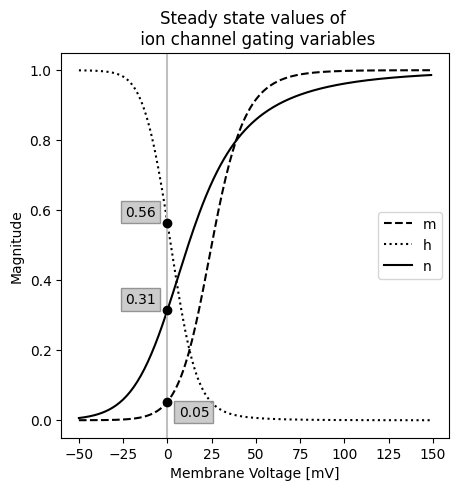

In [7]:
plt.figure(figsize=(5, 5))
plt.plot(V, m, label='m', c='k', ls='--')
plt.plot(V, h, label='h', c='k', ls=':')
plt.plot(V, n, label='n', c='k', ls='-')
plt.axvline(0, c='silver')

bbox_props = dict(boxstyle="Square,pad=0.3", fc="silver", ec="gray", lw=1, alpha=0.8)
plt.text(15, model.m_0 - 0.03,
            f'{model.m_0:.2f}',
            ha="center", va="center",
            bbox=bbox_props)
plt.text(-15, model.h_0 + 0.03,
            f'{model.h_0:.2f}',
            ha="center", va="center",
            bbox=bbox_props)
plt.text(-15, model.n_0 + 0.03,
            f'{model.n_0:.2f}',
            ha="center", va="center", 
            bbox=bbox_props)

plt.scatter(
    [0, 0, 0],
    [model.m_0, model.h_0, model.n_0],
    color='k',
    zorder=10
)

plt.title('Steady state values of \n ion channel gating variables')
plt.xlabel('Membrane Voltage [mV]')
plt.ylabel('Magnitude')

plt.legend()
plt.show()

The model was expected to respond to a step signal defined as

\begin{equation}
    I =
    \begin{cases}
        0,    & (t \lt t_e) \cup (t_s \le t)\\
        I_0,  & (t_e \le t \lt g_s)
    \end{cases}
\end{equation}

In [8]:
def rectangle_signal(f):
    def func(t):
        return f * np.heaviside(t - 50, 1) * np.heaviside(-t + 300, 1)
    return func

Simulations were performed for $I_0 \in \{0, 3, 6, 8\}$ mV for the rectangle signal.
The results are plotted below revealing a spiking behaviour of the neurite.

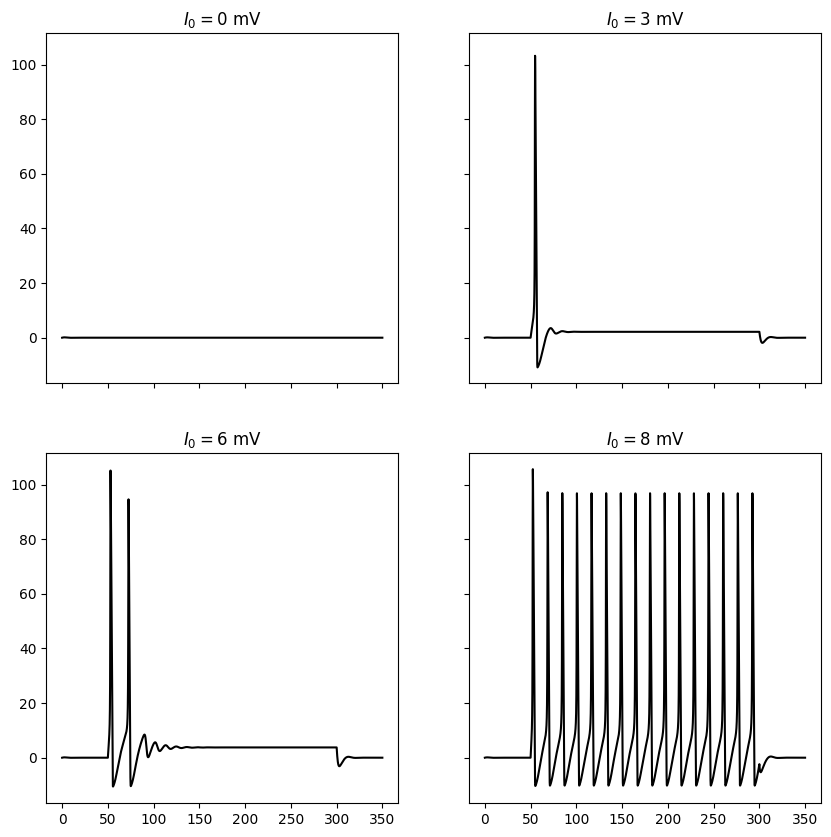

In [9]:
I_0s = [0, 3, 6, 8]

plt.style.use('default')
fig, axs = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10, 10))
axs = axs.flatten()

for I_0, ax in zip(I_0s, axs):
    ts, V, I, m, h, n = model.response(rectangle_signal(I_0), start=0, end=350)
    
    ax.plot(ts, V, 'k')
    ax.set_title(f'$I_0 = {I_0}$ mV')

plt.show()

Next a heaviside response has expected so the following equation was implemented

\begin{equation}
    I =
    \begin{cases}
        0,    & (t \lt t_e) \\
        I_0,  & (t \ge t_e)
    \end{cases}
\end{equation}

In [10]:
def heaviside(f):
    def func(t):
        return f * np.heaviside(t, 1)
    return func

The neuron model was tested on a range of input amplitudes from 0 to 20 $\mu$V.
Then the firing rate was calculated by finding the number of points in time were the value was equal to 50 and had an positive first derivative.

The comparison of signal amplitude and firing rate is plotted on the graph below. 

In [11]:
spikes = []
I_0s = np.arange(0, 21, 1)
dt = 0.025
end = 810
steady = 10
threshold = 50

for I_0 in I_0s:
    ts, V, I, m, h, n = model.response(heaviside(I_0), start=0, end=end, dt=dt)
    
    steady_state_start = int(np.ceil(steady / 0.025))
    V = V[steady_state_start:]
    
    V[V < threshold] = 0
    V[V >= threshold] = 1
    dV = np.diff(V)

    spike_count = len(np.where(dV > 0)[0])
    spike_freq = spike_count / (end - steady) * 1e3

    spikes.append(spike_freq)

A Heaviside like response function can be observed

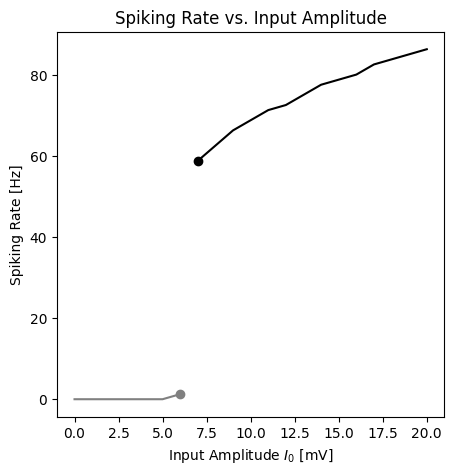

In [12]:
spikes = np.array(spikes)

plt.figure(figsize=(5, 5))
plt.plot(I_0s[spikes < 10], spikes[spikes < 10], 'gray')
plt.plot(I_0s[spikes >= 10], spikes[spikes >= 10], 'k')
plt.scatter([I_0s[spikes < 10][-1]], [spikes[spikes < 10][-1]], c='gray')
plt.scatter([I_0s[spikes >= 10][0]], [spikes[spikes >= 10][0]], c='k')
plt.title('Spiking Rate vs. Input Amplitude')
plt.xlabel('Input Amplitude $I_0$ [mV]')
plt.ylabel('Spiking Rate [Hz]')
plt.show()
